### *This is not the last and complete version.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from math import cos as cos
from math import sin as sin
from math import pi as pi
import random


from scipy.sparse import csr_matrix, lil_matrix
import scipy as sp

In [2]:
def random_initializing():
    '''
    set a random cone's parameters
    return : R_0 = (x_0,y_0,z_0),n = (n_x,n_y,n_z),thta_cs
    
    '''
    theta_cs = np.random.uniform(0,pi/2)
    theta = np.random.uniform(0,pi)
    phi = np.random.uniform(0,2*pi)
    x_0 = np.random.uniform(-1,1)
    y_0 = np.random.uniform(-1,1)
    z_0 = np.random.uniform(-1,1)
    n_x = sin(theta) * cos(phi) 
    n_y = sin(theta) * sin(phi) 
    n_z = cos(theta) 
    return x_0,y_0,z_0,theta_cs,n_x,n_y,n_z

In [3]:
def space(mesh_theta,mesh_phi):
    '''
    discrete the parameter space: divide theta into (mesh_theta = N_theta = pi / delta_theta) parts
                                  divide phi into (mesh_phi = N_phi = 2 pi / delta_phi) parts
    return: a mesh_theta*mesh_phi dimension matrix wich its elements are theta,phi of that point
    
    '''
    #Meshgrid
    phi = np.linspace(0, 2*pi , mesh_phi)
    theta = np.linspace(0, pi , mesh_theta)
    phi_s, theta_s = np.meshgrid(phi,theta)
    return phi_s,theta_s

In [4]:
def cone_sphere_intersection_with_error(x_0,y_0,z_0,theta_cs,n_x,n_y,n_z,phi_s,theta_s,mesh_theta,mesh_phi):
    '''
    find intersection curve's points numerically(by finding error for all possible theta and phi) and show them with a matrix which its nonzero(1) elements are intersection points
    input : x_0,y_0,z_0,theta_cs,n_x,n_y,n_z : cone parameters
            phi_s,theta_s : from "space" function - discrete parameter space
            mesh_theta,mesh_phi : they use for calculate the error (find delta_theta and delta_phi)
    return : a mesh_theta*mesh_phi dimension matrix which its nonzero(1) elements are intersection points
    
    '''
    
    delta_theta = pi / mesh_theta
    delta_phi = 2 * pi / mesh_phi
    
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s) 
    sin_phi = np.sin(phi_s)
    cos_phi = np.cos(phi_s)
    
    X = sin_theta * cos_phi - x_0
    Y = sin_theta * sin_phi - y_0
    Z = cos_theta - z_0
    rsize = np.sqrt(X**2 + Y**2 + Z**2)
    
    function = X * n_x + Y * n_y + Z * n_z - np.multiply(rsize,np.cos(theta_cs))
    
    deltaf_deltatheta = cos_theta * (cos_phi * n_x + sin_phi * n_y) - sin_theta * n_z + np.cos(theta_cs) * np.divide((cos_theta * (cos_phi * x_0 + sin_phi * y_0) - sin_theta * z_0) , rsize)
    deltaf_deltaphi = sin_theta * (cos_phi * n_y - sin_phi * n_x) + np.cos(theta_cs) * sin_theta * np.divide((cos_phi * y_0 - sin_phi * x_0) , rsize)
    error_function = np.sqrt(np.add(np.multiply(deltaf_deltaphi,deltaf_deltaphi) * (delta_phi) ** 2,np.multiply(deltaf_deltatheta,deltaf_deltatheta) * (delta_theta) ** 2))
    
    function[abs(function) <= error_function] = 0
    function[abs(function) != 0] = -1
    function = function + 1
    if function.any() == 0:
        theta_cs = -1 # for cones which have no interaction
        
    return function, theta_cs

In [5]:
def data_genarate_with_error_random(mesh_theta,mesh_phi,phi_s,theta_s):
    '''
    find intersection curve's points numerically(by finding error for all possible theta and phi) for a random cone and show them with a matrix which its nonzero(1) elements are intersection points
    input :mesh_theta,mesh_phi : they use for calculate the error (find delta_theta and delta_phi)
    return : intersection :a mesh_theta*mesh_phi dimension sparse matrix which its nonzero(1) elements are intersection points
             x_0,y_0,z_0,theta_cs,n_x,n_y,n_z : the random cone's parameters
    '''
    #phi_s,theta_s = space(mesh_theta,mesh_phi)
    x_0,y_0,z_0,theta_cs,n_x,n_y,n_z = random_initializing()
    intersection, theta_cs = cone_sphere_intersection_with_error(x_0,y_0,z_0,theta_cs,n_x,n_y,n_z,phi_s,theta_s,mesh_theta,mesh_phi)
    return sp.sparse.csr_matrix(intersection.reshape(-1)),x_0,y_0,z_0,theta_cs,n_x,n_y,n_z

In [6]:
def sample(n_sample,mesh_theta,mesh_phi):
    '''
    generate data with special shape for our estimator
    input :mesh_theta,mesh_phi : number of features = mesh_theta*mesh_phi -> reshape(-1)
    return : x: shape(n_sample,n_feature) sparse matrix for optimization the run run time
             y: shape(n_sample,1) 1 output-theta_cs as an output
             the data just include cones with intersection
    '''
    x = lil_matrix((n_sample,mesh_theta * mesh_phi))
    y = np.zeros((n_sample))
    phi_s,theta_s = space(mesh_theta,mesh_phi)
    i = 0
    while i < n_sample:
        intersection,x_0,y_0,z_0,theta_cs,n_x,n_y,n_z = data_genarate_with_error_random(mesh_theta,mesh_phi,phi_s,theta_s)
        if theta_cs != -1: # creat samples just with cones that have interaction
            y[i] = theta_cs
            x[i,:] = sp.sparse.csr_matrix(intersection)
            i = i + 1
    return x, y

In [7]:
mesh_theta, mesh_phi = 1000, 2000
phi_s1,theta_s1 = space(mesh_theta,mesh_phi)
phi_s2,theta_s2 = space(mesh_theta,mesh_phi)

theta_1, phi_1 = 70*pi/180, 100*pi/180

x_01, y_01, z_01, theta_cs1, n_x1, n_y1, n_z1 = 0.3, 0.6, -0.2, 70*pi/180, sin(theta_1) * cos(phi_1), sin(theta_1) * sin(phi_1), cos(theta_1) 

theta_2, phi_2 = 40*pi/180, 70*pi/180

x_02, y_02, z_02, theta_cs2, n_x2, n_y2, n_z2 = -0.1, 0.2, 0.1, 30*pi/180, sin(theta_2) * cos(phi_2), sin(theta_2) * sin(phi_2), cos(theta_2) 


In [8]:
intersection1, theta_cs1 = cone_sphere_intersection_with_error(x_01,y_01,z_01,theta_cs1,n_x1,n_y1,n_z1,phi_s1,theta_s1,mesh_theta,mesh_phi)
intersection2, theta_cs2 = cone_sphere_intersection_with_error(x_02,y_02,z_02,theta_cs2,n_x2,n_y2,n_z2,phi_s2,theta_s2,mesh_theta,mesh_phi)

In [9]:
shape = ((intersection1 + intersection2) > 0).astype(int)

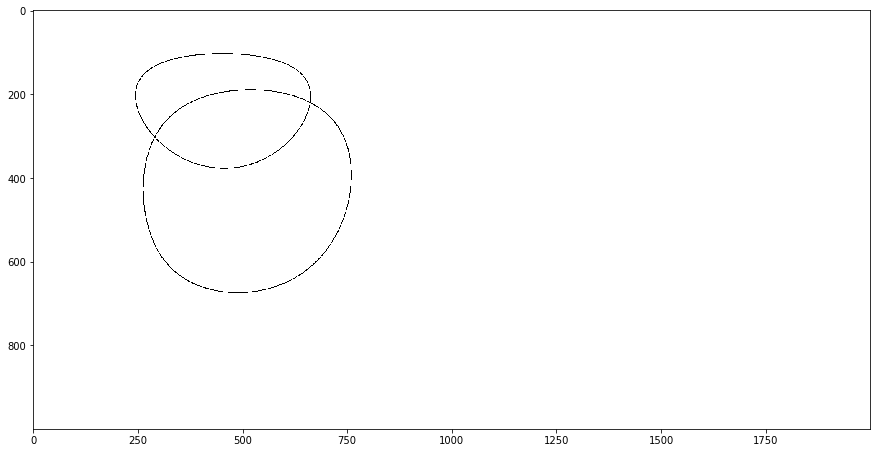

In [10]:
plt.rcParams['figure.figsize'] = 15,15
plt.imshow(shape,cmap = "Greys")

In [11]:
on_points = np.nonzero(shape)

In [12]:
y_max = np.max(on_points[0])
y_min = np.min(on_points[0])
x_min = np.min(on_points[1])
x_max = np.max(on_points[1])

In [13]:
shape_finded = shape[y_min-1:y_max+1, x_min-1:x_max+1]

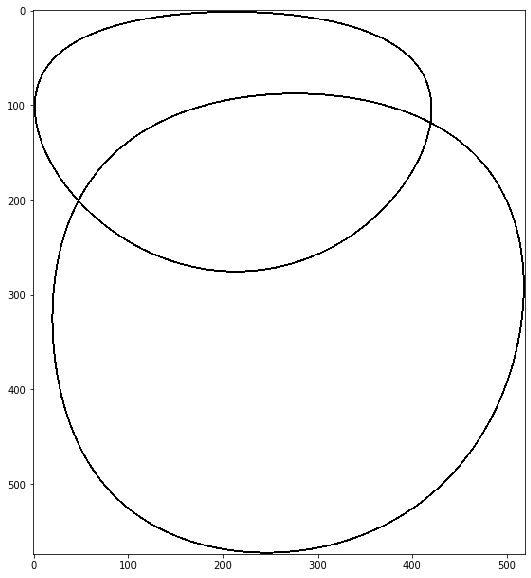

In [80]:
plt.rcParams['figure.figsize'] = 10,10
plt.imshow(shape_finded,cmap = "Greys")

In [15]:
n_H, n_W = shape_finded.shape[0], shape_finded.shape[1]
fs = 5
ps = (fs - 1)//2

In [16]:
coarse_grained = np.zeros((n_H+2*ps, n_W+2*ps))

In [17]:
coarse_grained[ps:-ps, ps:-ps] = np.copy(shape_finded)

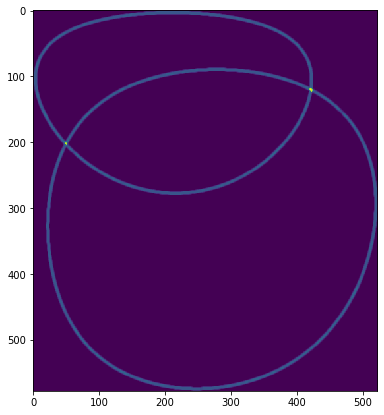

In [18]:
from scipy import ndimage
plt.rcParams['figure.figsize'] = 7, 7
limit = 14
one_conv = np.ones((fs, fs)).astype(int)
img = (ndimage.convolve(coarse_grained, one_conv))
plt.imshow(img + (img>limit)*img)
ax = plt.gca()
ax.set_aspect('equal')

In [19]:
Filter_intersections = img>limit

In [20]:
original_img = np.copy(coarse_grained)
filter_img = Filter_intersections*original_img*2 + original_img

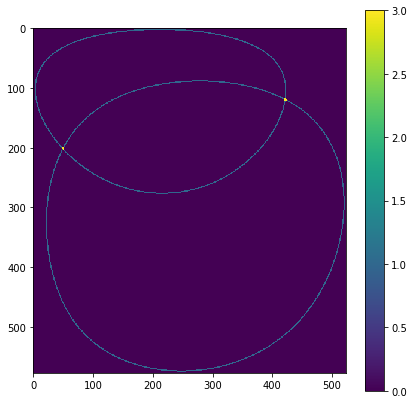

In [21]:
plt.imshow(filter_img)
plt.colorbar()

# Tracing Curve

In [22]:
window_size = 10
trace_window = np.zeros((window_size, 2*window_size))
x_0 = 50
y_0 = 50
Lx = filter_img.shape[1]
Ly = filter_img.shape[0]
work_space = np.zeros((Ly + 4*window_size, Lx + 8*window_size))
work_space[2*window_size:-2*window_size, 4*window_size:-4*window_size] = np.copy(filter_img)

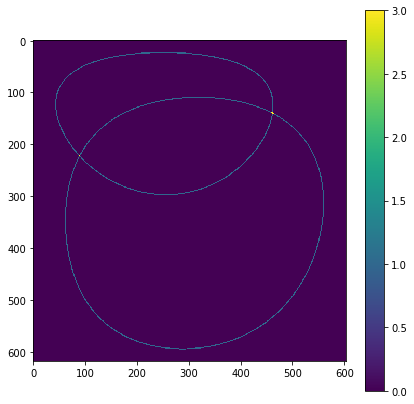

In [23]:
plt.imshow(work_space)
plt.colorbar()

In [24]:
from math import sqrt
def window_grad(window, window_size, x_c, y_c):
    flag = 0
    L = window_size*2 + 2*(window_size-2)
    #print(L)
    border_up = window[0,:]
    border_right = window[1:-1,-1]
    border_down = window[-1,:]
    border_left = window[1:-1,0]
    # border of the window
    border = np.concatenate([border_up, border_right, border_down[::-1], border_left[::-1]]).astype(float)
    
    # count nonzero neighbors 
    m = border!=0
    m = m.astype(int)
    r = np.roll(m,1)
    s = r - m
    right_lim = np.nonzero(np.roll(s,-1)>0)[0]
    left_lim = np.nonzero(s<0)[0]
    
    N_road = len(right_lim)
    
    if N_road == 2:
        NB1 = (right_lim[0]+left_lim[0])//2
        NB2 = (right_lim[1]+left_lim[1])//2
        
        NB1_cor = border_coordinate[NB1]
        NB2_cor = border_coordinate[NB2]
        
        
        delta_x = NB2_cor[0] - NB1_cor[0]
        delta_y = NB2_cor[1] - NB1_cor[1]
        dl = sqrt(delta_x**2 + delta_y**2)
        
        rondx = delta_x / dl
        rondy = delta_y / dl
        
        #

        if np.count_nonzero(window == 1) == 0:
            rondx = -rondx + 0.1*np.random.rand()
            rondy = -rondy + 0.1*np.random.rand()
            
        
    
#         # circle
#         theta = np.arctan2(rondy,rondx)
#         theta0 = np.arctan2(grad_memory[-1][1],grad_memory[-1][0])
        
#         if abs(theta - theta0) > np.pi/10:
#             rondx = (grad_memory[-1][0]+rondx)/2
#             rondy = (grad_memory[-1][1]+rondy)/2
        
        #color the window
        mask = np.copy(window)
        mask[mask>0] = 2
        work_space[int(y_c):int(y_c+window_size), int(x_c):int(x_c+2*window_size)] = np.copy(mask)
        
        # correced X_c & Y_c
        x_c = x_c + (NB2_cor[0] + NB1_cor[0])//2 - window_size
        y_c = y_c + (NB2_cor[1] + NB1_cor[1])//2 - window_size//2
        
        
        
        flag = 1
    else:
        flag = 0
        rondx, rondy = 0, 0
    
    return rondx, rondy, x_c, y_c, flag
        

In [25]:
def move_window(x_c, y_c, window_size):
    window = work_space[int(y_c):int(y_c+window_size),int(x_c):int(x_c+2*window_size)]
    return window

In [26]:
window_size = 10
trace_window = np.zeros((window_size, 2*window_size))
x_0 = 50
y_0 = 50
Lx = filter_img.shape[1]
Ly = filter_img.shape[0]
work_space = np.zeros((Ly + 2*window_size, Lx + 4*window_size))
work_space[window_size:-window_size, 2*window_size:-2*window_size] = np.copy(filter_img)


In [27]:
border_coordinate = []
for i in range(2*window_size):
    border_coordinate.append([i+1, 1])
    
for i in range(window_size-2):
    border_coordinate.append([2*window_size, i+2])
    
for i in range(2*window_size):
    border_coordinate.append([2*window_size-i, window_size])
    
for i in range(window_size-2):
    border_coordinate.append([1,window_size-i-1])

In [28]:
on_curve_points = np.nonzero(work_space)
N = np.count_nonzero(work_space)
N

5341

In [29]:

n_step = 5000
i = 500
x_c, y_c = on_curve_points[1][i], on_curve_points[0][i]
#x_c, y_c = 200,180
step = 3
h = 3
X = []
Y = []
grad_memory = [[0.7071067811865476, -0.7071067811865476]]
flag = 0
for i in range(n_step):
    
    window = move_window(x_c, y_c, window_size)
    X.append(x_c)
    Y.append(y_c)
    if np.count_nonzero(window > 2):
        #print('wo')
        x_c = int(x_c + (grad_memory[-3][0]+grad_memory[-2][0]+grad_memory[-1][0])/3*4*step)
        y_c = int(y_c + (grad_memory[-3][1]+grad_memory[-2][1]+grad_memory[-1][1])/3*4*step)
#         x_c = int(x_c + grad_memory[-1][0]*h + 0.5 * (grad_memory[-1][0] - grad_memory[-2][0])/(X[-1] - X[-2]+1) * h**2)
#         y_c = int(y_c + grad_memory[-1][1]*h + 0.5 * (grad_memory[-1][1] - grad_memory[-2][1])/(Y[-1] - Y[-2]+1) * h**2)
        
        
    else:
        
        
        dx, dy, x_c, y_c, flag = window_grad(window, window_size, x_c, y_c)
        
#         if i>20 and abs(np.mean(X[-10:-1]) - X[-1])<2:
#             print('loop',X[-1], abs(np.mean(X[-10:-1]) - X[-1]))
#             x_c = x_c + (np.random.randint(0,2))
#             y_c = y_c + (np.random.randint(0,2))
        if flag == 1:
#             x_c = int(x_c + (dx+0.1*np.random.rand())*step)
#             y_c = int(y_c + (dy+0.1*np.random.rand())*step)
            x_c = int(x_c + (dx)*step)
            y_c = int(y_c + (dy)*step)
            grad_memory.append([dx, dy])
            #print('yes')
        else:
            #print('else')
#             x_c = int(x_c + (grad_memory[-1][0] + 0.001*np.random.rand())/2*step)
#             y_c = int(y_c + (grad_memory[-1][1] + 0.001*np.random.rand())/2*step)
            x_c = int(x_c + (grad_memory[-1][0])/2*step)
            y_c = int(y_c + (grad_memory[-1][1])/2*step)
        

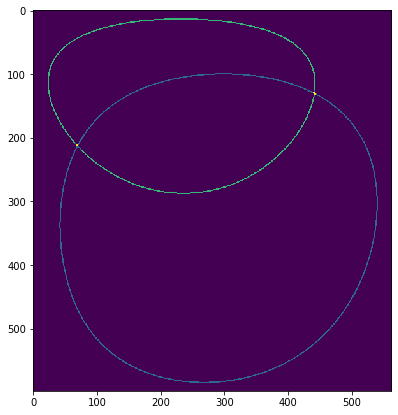

In [30]:
plt.imshow(work_space)

In [31]:
curve_1 = np.copy(work_space)
curve_1[curve_1 == 1] = 0
intersection_curve_12 = np.copy(curve_1)
intersection_curve_12[intersection_curve_12 != 3] = 0
curve_1[curve_1>0] = 1
work_space[work_space == 2] = 0
work_space = work_space - 2/3*intersection_curve_12

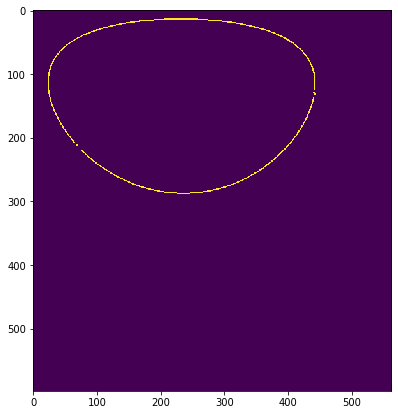

In [32]:
plt.imshow(curve_1)

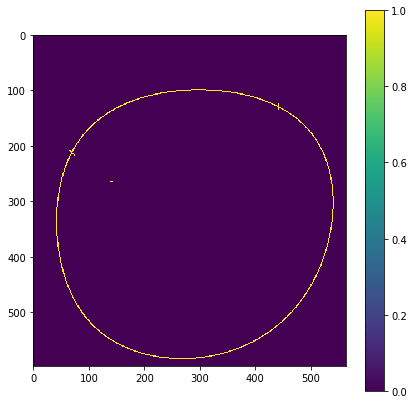

In [33]:
plt.imshow(work_space)
plt.colorbar()